# A POS tagger based on deep neural network

## Creating Vocabulary from the training data
First we should read from data file. The data looks like the following
```txt
Two     NUM
of      ADP
them    PRON
were    AUX
being   AUX
run     VERB
by      ADP
2       NUM
officials       NOUN
of      ADP
the     DET
Ministry        PROPN
of      ADP
the     DET
Interior        PROPN
!       PUNCT

The     DET
MoI     PROPN
in      ADP
Iraq    PROPN
is      AUX
equivalent      ADJ
to      ADP
the     DET
US      PROPN
FBI     PROPN
,       PUNCT
so      ADV
this    PRON
would   AUX
be      VERB
like    SCONJ
having  VERB
J.      PROPN
Edgar   PROPN
Hoover  PROPN
unwittingly     ADV
employ  VERB
at      ADP
a       DET
high    ADJ
level   NOUN
members NOUN
of      ADP
the     DET
Weathermen      PROPN
bombers NOUN
back    ADV
in      ADP
the     DET
1960s   NOUN
.       PUNCT


```

In [1]:
data_path = 'data/en.pos.train'
sentences = open(data_path, 'r').read().strip().split('\n\n')

Then we should count the frequency of words and pos tags

In [2]:
from collections import defaultdict

word_count, tags = defaultdict(int), set()
for sentence in sentences:
    lines = sentence.strip().split('\n')
    for line in lines:
        word, tag = line.strip().split('\t')
        word_count[word] += 1
        tags.add(tag)
tags = list(tags)

Now we assume that words with frequency less than one should be disregarded.

In [3]:
words = [word for word in word_count.keys() if word_count[word]>1]

We should also take into account special symbols start of a sentence and end of a sentence

In [4]:
words = ['<UNK>', '<s>', '</s>'] + words
feat_tags = ['<s>'] + tags
output_tags = tags

We should also create string to integer mapping (because neural network libraries work with integers)

In [5]:
word_dict = {word: i for i, word in enumerate(words)}
feat_tags_dict = {tag: i for i, tag in enumerate(feat_tags)}
output_tag_dict = {tag: i for i, tag in enumerate(output_tags)}

We define some auxiliary functions to access the words, tag feature and tag output

In [6]:
def tagid2tag_str(id):
    return output_tags[id]

def tag2id(tag):
    return output_tag_dict[tag]

def feat_tag2id(tag):
    return feat_tags_dict[tag]

def word2id(word):
    return word_dict[word] if word in word_dict else word_dict['<UNK>']

def num_words():
    return len(words)

def num_tag_feats():
    return len(feat_tags)

def num_tags():
    return len(output_tags)

# Converting training data to a csv-style format

In [7]:
sens = open(data_path, 'r').read().strip().split('\n\n')
writer = open(data_path+'.data', 'w')

for sen in sens:
    lines = sen.strip().split('\n')
    ws, ts = ['<s>', '<s>'], ['<s>', '<s>']
    for line in lines:
        word, tag = line.strip().split()
        ws.append(word)
        ts.append(tag)
    ws += ['</s>', '</s>']

    for i in range(len(lines)):
        feats = [ws[i], ws[i + 1], ws[i + 2], ws[i + 3], ws[i + 4], ts[i], ts[i + 1]]
        label = ts[i + 2]
        writer.write('\t'.join(feats) + '\t' + label + '\n')
writer.close()


The output data should look like the following (__first 5 are word features, the other two are pos features, the last is the pos label__)
```txt
<s>     <s>     Al      -       Zaman   <s>     <s>     PROPN
<s>     Al      -       Zaman   :       <s>     PROPN   PUNCT
Al      -       Zaman   :       American        PROPN   PUNCT   PROPN
-       Zaman   :       American        forces  PUNCT   PROPN   PUNCT
Zaman   :       American        forces  killed  PROPN   PUNCT   ADJ
:       American        forces  killed  Shaikh  PUNCT   ADJ     NOUN
American        forces  killed  Shaikh  Abdullah        ADJ     NOUN    VERB
forces  killed  Shaikh  Abdullah        al      NOUN    VERB    PROPN
killed  Shaikh  Abdullah        al      -       VERB    PROPN   PROPN
Shaikh  Abdullah        al      -       Ani     PROPN   PROPN   PROPN
Abdullah        al      -       Ani     ,       PROPN   PROPN   PUNCT
al      -       Ani     ,       the     PROPN   PUNCT   PROPN
-       Ani     ,       the     preacher        PUNCT   PROPN   PUNCT
Ani     ,       the     preacher        at      PROPN   PUNCT   DET
,       the     preacher        at      the     PUNCT   DET     NOUN
the     preacher        at      the     mosque  DET     NOUN    ADP
preacher        at      the     mosque  in      NOUN    ADP     DET
at      the     mosque  in      the     ADP     DET     NOUN
the     mosque  in      the     town    DET     NOUN    ADP
mosque  in      the     town    of      NOUN    ADP     DET
in      the     town    of      Qaim    ADP     DET     NOUN
the     town    of      Qaim    ,       DET     NOUN    ADP
town    of      Qaim    ,       near    NOUN    ADP     PROPN
of      Qaim    ,       near    the     ADP     PROPN   PUNCT
Qaim    ,       near    the     Syrian  PROPN   PUNCT   ADP
,       near    the     Syrian  border  PUNCT   ADP     DET
near    the     Syrian  border  .       ADP     DET     ADJ
the     Syrian  border  .       </s>    DET     ADJ     NOUN
Syrian  border  .       </s>    </s>    ADJ     NOUN    PUNCT
<s>     <s>     [       This    killing <s>     <s>     PUNCT
<s>     [       This    killing of      <s>     PUNCT   DET
[       This    killing of      a       PUNCT   DET     NOUN
This    killing of      a       respected       DET     NOUN    ADP
killing of      a       respected       cleric  NOUN    ADP     DET
of      a       respected       cleric  will    ADP     DET     ADJ
a       respected       cleric  will    be      DET     ADJ     NOUN
respected       cleric  will    be      causing ADJ     NOUN    AUX
cleric  will    be      causing us      NOUN    AUX     AUX
will    be      causing us      trouble AUX     AUX     VERB
be      causing us      trouble for     AUX     VERB    PRON
```

# Defining the network
Here are the steps
    1. Importing the Dynet package
    2. Defining the model
    3. Defining the updater
    4. Defining embedding parameters and other layers

In [8]:
import dynet as dynet

Import some auxiliary packages

In [9]:
%matplotlib nbagg
import random
import matplotlib.pyplot as plt
import numpy as np

Steps in deep network design
1. Define the model (parameter container)
2. Define updater (e.g. SGD or ADAM) and bound it to the model
3. Define parameters (embeddings and other parameters)

In [10]:
# first initialize a computation graph container (or model).
model = dynet.Model()

In [11]:
# assign the algorithm for backpropagation updates.
updater = dynet.AdamTrainer(model)

In [12]:
# create embeddings for words and tag features.
word_embed_dim, pos_embed_dim = 100, 50
word_embedding = model.add_lookup_parameters((num_words(), word_embed_dim))
tag_embedding = model.add_lookup_parameters((num_tag_feats(), pos_embed_dim))

In [13]:
# assign transfer function
transfer = dynet.rectify  # can be dynet.logistic or dynet.tanh as well.

In [14]:
# define the input dimension for the embedding layer.
# here we assume to see two words after and before and current word (meaning 5 word embeddings)
# and to see the last two predicted tags (meaning two tag embeddings)
input_dim = 5 * word_embed_dim + 2 * pos_embed_dim

hidden_dim, minibatch_size = 200, 1000

# define the hidden layer.
hidden_layer = model.add_parameters((hidden_dim, input_dim))

# define the hidden layer bias term and initialize it as constant 0.2.
hidden_layer_bias = model.add_parameters(hidden_dim, init=dynet.ConstInitializer(0.2))

# define the output weight.
output_layer = model.add_parameters((num_tags(), hidden_dim))

# define the bias vector and initialize it as zero.
output_bias = model.add_parameters(num_tags(), init=dynet.ConstInitializer(0))

# Implementing the Forward function


In [15]:
def forward(features):
   # extract word and tags ids
   word_ids = [word2id(word_feat) for word_feat in features[0:5]]
   tag_ids = [feat_tag2id(tag_feat) for tag_feat in features[5:]]

   # extract word embeddings and tag embeddings from features
   word_embeds = [word_embedding[wid] for wid in word_ids]
   tag_embeds = [tag_embedding[tid] for tid in tag_ids]

   # concatenating all features (recall that '+' for lists is equivalent to appending two lists)
   embedding_layer = dynet.concatenate(word_embeds + tag_embeds)
    
   # calculating the hidden layer
   # .expr() converts a parameter to a matrix expression in dynetnet (its a dynetnet-specific syntax).
   hidden = transfer(hidden_layer.expr() * embedding_layer + hidden_layer_bias.expr())

   # calculating the output layer
   output = output_layer.expr() * hidden + output_bias.expr()

   # return a list of outputs
   return output

# Implementing the Decoder

In [16]:
def decode(ws):
   # first putting two start symbols
   ws = ['<s>', '<s>'] + ws + ['</s>', '</s>']
   ts = ['<s>', '<s>']

   for i in range(2, len(ws) - 2):
       features = ws[i - 2:i + 3] + ts[i - 2:i]

       # running forward
       output = forward(features)

       # getting list value of the output
       scores = output.npvalue()

       # getting best tag
       best_tag_id = np.argmax(scores)

       # assigning the best tag
       ts.append(tagid2tag_str(best_tag_id))

       # refresh dynet memory (computation graph)
       dynet.renew_cg()

   return ts[2:]

# Training with backpropagation

## Setting the MatplotLib setting

<IPython.core.display.Javascript object>


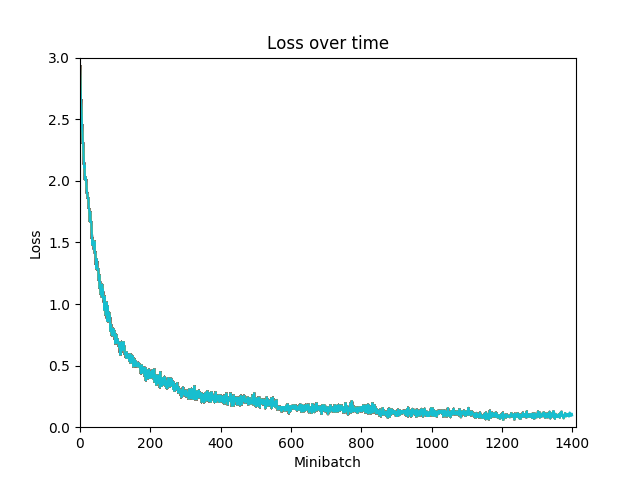

In [17]:
# matplotlib config
loss_values = []
plt.ion()
ax = plt.gca()
ax.set_xlim([0, 10])
ax.set_ylim([0, 3])
plt.title("Loss over time")
plt.xlabel("Minibatch")
plt.ylabel("Loss")
plt.show()

In [18]:
def plot(loss_values):
    ax.set_xlim([0, len(loss_values)+10])
    ax.plot(loss_values)
    plt.draw()
    try:
       plt.pause(0.0001)
    except: pass

## Reading the training data into a list

In [19]:
train_data = open(data_path+'.data', 'r').read().strip().split('\n')

In [20]:
def train_iter(train_data):
        losses = [] # minibatch loss vector
        random.shuffle(train_data) # shuffle the training data.

        for line in train_data:
            fields = line.strip().split('\t')
            features, label, gold_label = fields[:-1], fields[-1], tag2id(fields[-1])
            result = forward(features)

            # getting loss with respect to negative log softmax function and the gold label; and appending to the minibatch losses.
            loss = dynet.pickneglogsoftmax(result, gold_label)
            losses.append(loss)

            if len(losses) >= minibatch_size:
                minibatch_loss = dynet.esum(losses) / len(losses) # now we have enough loss values to get loss for minibatch
                minibatch_loss.forward() # calling dynetnet to run forward computation for all minibatch items
                minibatch_loss_value = minibatch_loss.value() # getting float value of the loss for current minibatch

                # printing info and plotting
                loss_values.append(minibatch_loss_value)
                
                if len(loss_values)%10==0: plot(loss_values)
                                    
                minibatch_loss.backward() # calling dynetnet to run backpropagation
                updater.update() # calling dynet to change parameter values with respect to current backpropagation

                # empty the loss vector and refresh the memory of dynetnet
                losses = []
                dynet.renew_cg()

        dynet.renew_cg() # there are still some minibatch items in the memory but they are smaller than the minibatch size

# Saving and loading network

In [21]:
def load(filename):
    model.populate(filename)

def save(filename):
    model.save(filename)

# Training epochs

In [22]:
for i in range(5):
    print 'epoch', (i+1)
    train_iter(train_data)
    dynet.renew_cg()
print 'finished training!'

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
finished training!


# Tagging a file

In [23]:
test_file = 'data/en.pos.dev.raw'
writer = open(test_file+'.output', 'w')
for sentence in open(test_file, 'r'):
    words = sentence.strip().split()
    tags = decode(words)
    output = [word + '\t' + tag for word, tag in zip(words, tags)]
    writer.write('\n'.join(output) + '\n\n')
writer.close()